<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
# import gdown

# url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
# output = 'Data.zip'
# gdown.download(url, output, quiet=False)

In [2]:
# import zipfile

# with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/')

## Описание данных

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. t_flag - флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


## Постановка задачи
 В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

## Декомпозиция задачи

### 1.	Сбор и анализ таргета (18 баллов)

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder
import optuna
from psi import calculate_psi
from catboost import CatBoostClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from sklift.models import (SoloModel, TwoModels, ClassTransformation,)
from sklift.viz import plot_qini_curve, plot_uplift_curve
from sklift.metrics import make_uplift_scorer, qini_auc_score

sns.set_palette("deep")
sns.set_style("darkgrid")
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
campaigns = pd.read_csv('D:/Datasets/HSE/ML/CAMPAINGS.csv', index_col='Unnamed: 0')
features = pd.read_csv('D:/Datasets/HSE/ML/AGGS_FINAL.csv', index_col='Unnamed: 0')
contracts = pd.read_csv('D:/Datasets/HSE/ML/CONTRACTS_FINAL.csv', index_col='Unnamed: 0')
people = pd.read_csv('D:/Datasets/HSE/ML/PEOPLE_IN_CAMPAINGS_FINAL.csv', index_col='Unnamed: 0')

In [5]:
display(campaigns)
for i in [features, contracts, people]:
    display(i.head(5))
    print(i.isna().sum())
    print(i.duplicated().sum())

,campaing_id,product_id,channel
0,iddqd,1,push
1,idclip,1,sms
2,iddt,1,banner
3,idkfa,1,other_ads


,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
104548,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
38396,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
227077,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
304649,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
239518,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


x1           0
x2           0
x3           0
x4           0
x5           0
x6           0
x7           0
x8           0
x9           0
report_dt    0
user_id      0
age          0
city         0
dtype: int64
0


,user_id,contract_date,product_id,contract_id
39735,4008279,2024-11-03,1,0001_2024-11-03_4008279
44062,2079035,2024-11-08,1,0001_2024-11-08_2079035
9286,103088,2024-11-13,1,0001_2024-11-13_103088
45573,2026788,2024-11-02,1,0001_2024-11-02_2026788
150378,52269,2024-11-17,1,0001_2024-11-17_52269


user_id          0
contract_date    0
product_id       0
contract_id      0
dtype: int64
0


,campaing_id,user_id,t_flag,delivery_date
29299,idclip,1099975,1,2024-11-06
36627,iddqd,1162,1,2024-11-08
134015,iddqd,42991,1,2024-11-07
57441,idclip,142343,0,unknown
48671,iddqd,24623,0,unknown


campaing_id      0
user_id          0
t_flag           0
delivery_date    0
dtype: int64
0


`Выводы`
* В исходных таблицах пропусков и дубликатов нет

In [6]:
# Соединяем таблицы
df = people.merge(campaigns, on='campaing_id', how='inner')
df = df.merge(contracts.drop(columns='product_id'), on='user_id', how='left')

display(df.head(5))
df.info()

,campaing_id,user_id,t_flag,delivery_date,product_id,channel,contract_date,contract_id
0,idclip,1099975,1,2024-11-06,1,sms,2024-11-11,0001_2024-11-11_1099975
1,iddqd,1162,1,2024-11-08,1,push,2024-11-13,0001_2024-11-13_1162
2,iddqd,42991,1,2024-11-07,1,push,NaN,NaN
3,idclip,142343,0,unknown,1,sms,2024-11-17,0001_2024-11-17_142343
4,iddqd,24623,0,unknown,1,push,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520000 entries, 0 to 519999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   campaing_id    520000 non-null  object
 1   user_id        520000 non-null  int64 
 2   t_flag         520000 non-null  int64 
 3   delivery_date  520000 non-null  object
 4   product_id     520000 non-null  int64 
 5   channel        520000 non-null  object
 6   contract_date  337635 non-null  object
 7   contract_id    337635 non-null  object
dtypes: int64(3), object(5)
memory usage: 31.7+ MB


`Таблицы успешно соединили`

In [7]:
# Приведём даты к типу datetime
df['delivery_date'] = pd.to_datetime(df['delivery_date'], errors='coerce')
df['contract_date'] = pd.to_datetime(df['contract_date'], errors='coerce')
features['report_dt'] = pd.to_datetime(features['report_dt'], errors='coerce')

# Cтавим старт кампании на 1 ноября (как по условию)
campaign_start = pd.to_datetime("2024-11-01")

In [8]:
# Окно дат для целевой группы (t_flag=1): delivery_date + 14 дней
# Окно дат для контрольной группы (t_flag=0): campaign_start + 21 день
df['cutoff_date'] = pd.to_datetime(np.where(
    df['t_flag'] == 1,
    df['delivery_date'] + pd.Timedelta(days=14),
    campaign_start + pd.Timedelta(days=21)))

# Если contract_date <= cutoff_date, то таргет = 1, иначе 0
df['target'] = ((df['contract_date'].notna()) 
                     & (df['contract_date'] <= df['cutoff_date'])).astype(int)

# Итоговая таблица по юзеру и каналу
target_by_user = (df.groupby(['channel','user_id'], as_index=False)['target'].max())

# Добавляем флаг группы (целевая, контрольная)
df_grouped = df[['channel', 'user_id', 't_flag']].merge(target_by_user, on=['channel','user_id'], how='left')

# Дата, на которую актуальны признаки
df_grouped['report_dt'] = campaign_start

df_grouped.head(5)

,channel,user_id,t_flag,target,report_dt
0,sms,1099975,1,1,2024-11-01
1,push,1162,1,1,2024-11-01
2,push,42991,1,0,2024-11-01
3,sms,142343,0,1,2024-11-01
4,push,24623,0,0,2024-11-01


In [9]:
# Считаем uplift по каждому каналу
df_agg = df_grouped.groupby(["channel", "report_dt", "t_flag"])["target"].mean().unstack()
df_agg["uplift"] = (df_agg[1] - df_agg[0])
df_agg

,t_flag,0,1,uplift
channel,report_dt,,,
banner,2024-11-01,0.400733,0.687750,0.287017
other_ads,2024-11-01,0.400733,0.702267,0.301533
push,2024-11-01,0.202150,0.687025,0.484875
sms,2024-11-01,0.684917,0.398617,-0.286300


`Выводы`
* Для всех типов коммуникаций (кроме sms) наблюдается положительный uplift, самое высокое значение - для канала push (0.48), то есть эти виды коммуникации увеличивают конверсию покупок товара.
* SMS - потенциально сломанная группа, среднее значение таргета у получивших коммуникацию меньше (0.4), чем у тех, кто не получал коммуникацию (0.68). Это может говорить о том, что рассылка sms уменьшает конверсию покупки товара или, что тоже возможно, группа, которая не получала SMS, изначально имела более высокую конверсию.

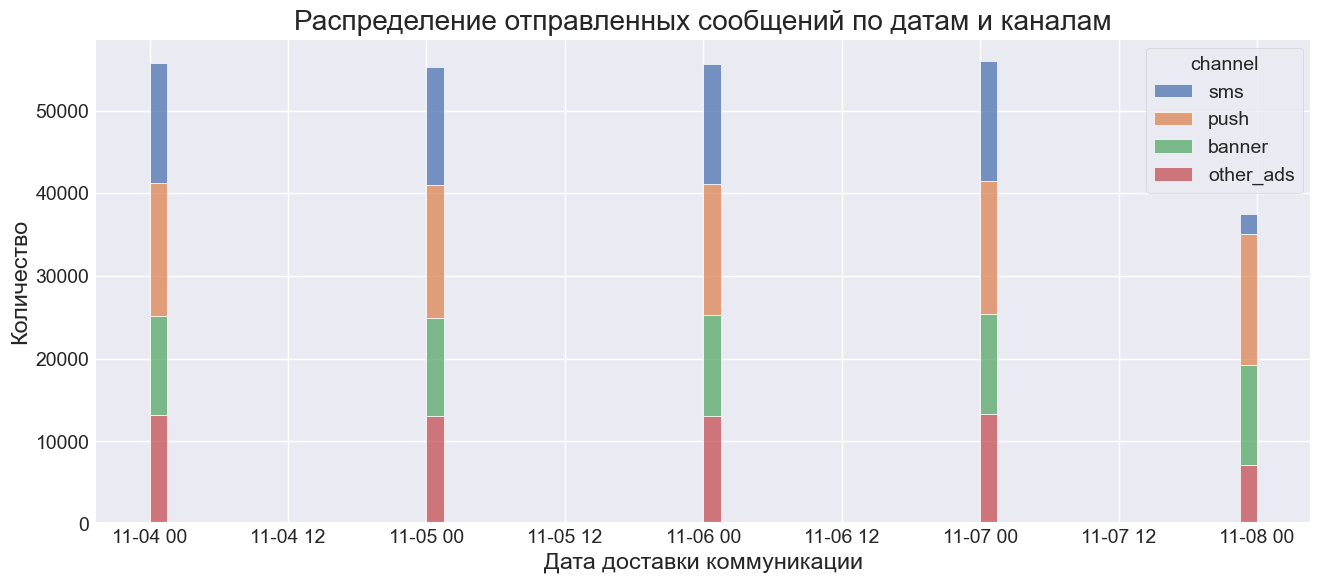

In [10]:
# Дополнительно проанализируем кампанию по рассылке коммуникаций
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='delivery_date', hue='channel', multiple='stack')
plt.xlabel("Дата доставки коммуникации")
plt.ylabel("Количество")
plt.title("Распределение отправленных сообщений по датам и каналам")
plt.show()

`Выводы `
* По графику видно, что sms и push наиболее массовые каналы по количеству сообщений, затем идут баннеры и other_ads, распределение долей по каналам внутри каждого дня остаётся примерно одинаковым

* Общее количество отправленных сообщений в даты 11–04, 11–05, 11–06 и 11–07 весьма схоже, тогда как на 11–08 видно заметное падение (возможно на момент выгрузки 11–08 был не полный день, либо действительно сократился объём отправлений)

* Интересно, что хотя кампания по рассылке SMS довольно массовая, но uplift эта кампания даёт негативный, продолжим расследование


In [11]:
# Проверим распределение пользователей между контрольными и целевыми группами
df_grouped_ = df_grouped.groupby('user_id', as_index=False)['channel'].count().query('channel>1')
display(df_grouped_)
df_grouped[df_grouped['user_id']==5]

,user_id,channel
0,1,2
4,5,2
5,6,2
9,10,2
13,14,2
...,...,...
159992,159993,2
159994,159995,2
159996,159997,2
159998,159999,2


,channel,user_id,t_flag,target,report_dt
149289,push,5,1,0,2024-11-01
388135,sms,5,0,0,2024-11-01


In [12]:
df_grouped[df_grouped['user_id'].isin(df_grouped_['user_id'])].groupby(['channel', 't_flag'], as_index=False)['user_id'].count()

,channel,t_flag,user_id
0,push,1,60000
1,sms,0,60000


`Выводы`
* Можем заметить, что есть целых 60 000 пользователей, которые находились в одной кампании в контрольной группе, при этом находясь в целевой группе другой кампании, проверим как удаление этих дублей повлияет на uplift

In [13]:
# Удаляем дубли по id и снова считаем uplift по каждому каналу
df_grouped_new = df_grouped.drop_duplicates(subset='user_id')
df_agg_new = df_grouped_new.groupby(["channel", "report_dt", "t_flag"])["target"].mean().unstack()
df_agg_new["uplift"] = (df_agg_new[1] - df_agg_new[0])
df_agg_new

,t_flag,0,1,uplift
channel,report_dt,,,
banner,2024-11-01,0.400733,0.687750,0.287017
other_ads,2024-11-01,0.400733,0.702267,0.301533
push,2024-11-01,0.202150,0.690302,0.488152
sms,2024-11-01,0.681581,0.398617,-0.282964


In [14]:
df_agg

,t_flag,0,1,uplift
channel,report_dt,,,
banner,2024-11-01,0.400733,0.687750,0.287017
other_ads,2024-11-01,0.400733,0.702267,0.301533
push,2024-11-01,0.202150,0.687025,0.484875
sms,2024-11-01,0.684917,0.398617,-0.286300


`Выводы`
* Удаление дублей пользователей не повлияло на uplift по группам, для канала sms он всё ещё отрицательный, верным решением кажется убрать эту кампанию из исследования, так и поступим

### 2. Клиентские агрегаты (12 баллов)

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [15]:
df_grouped_new = df_grouped_new[df_grouped_new['channel']!='sms']

# Выделяем аггрегаты за сентябрь (как по условию - учебные данные берём за дату -2 месяца от даты покупок)
features_september = features[features['report_dt'].dt.month == 9]

# Соединяем таблицы
df_merged = df_grouped_new.merge(features_september, on='user_id')

display(df_merged.shape)

df_merged.head(5)

(369939, 17)

,channel,user_id,t_flag,target,report_dt_x,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt_y,age,city
0,push,1162,1,1,2024-11-01,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,2024-09-30,39,Moscow
1,push,42991,1,0,2024-11-01,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,2024-09-30,43,Moscow
2,push,24623,0,0,2024-11-01,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,39,Ufa
3,banner,4001330,0,0,2024-11-01,-1.821441,-0.847392,1.020568,-1.611153,0.933913,0.236984,0.933495,0.795683,-0.812175,2024-09-30,30,Smolensk
4,other_ads,2008409,1,1,2024-11-01,-1.952636,-0.479671,1.067760,-1.521329,-0.687298,0.327018,1.052708,1.244605,-0.886796,2024-09-30,25,Moscow


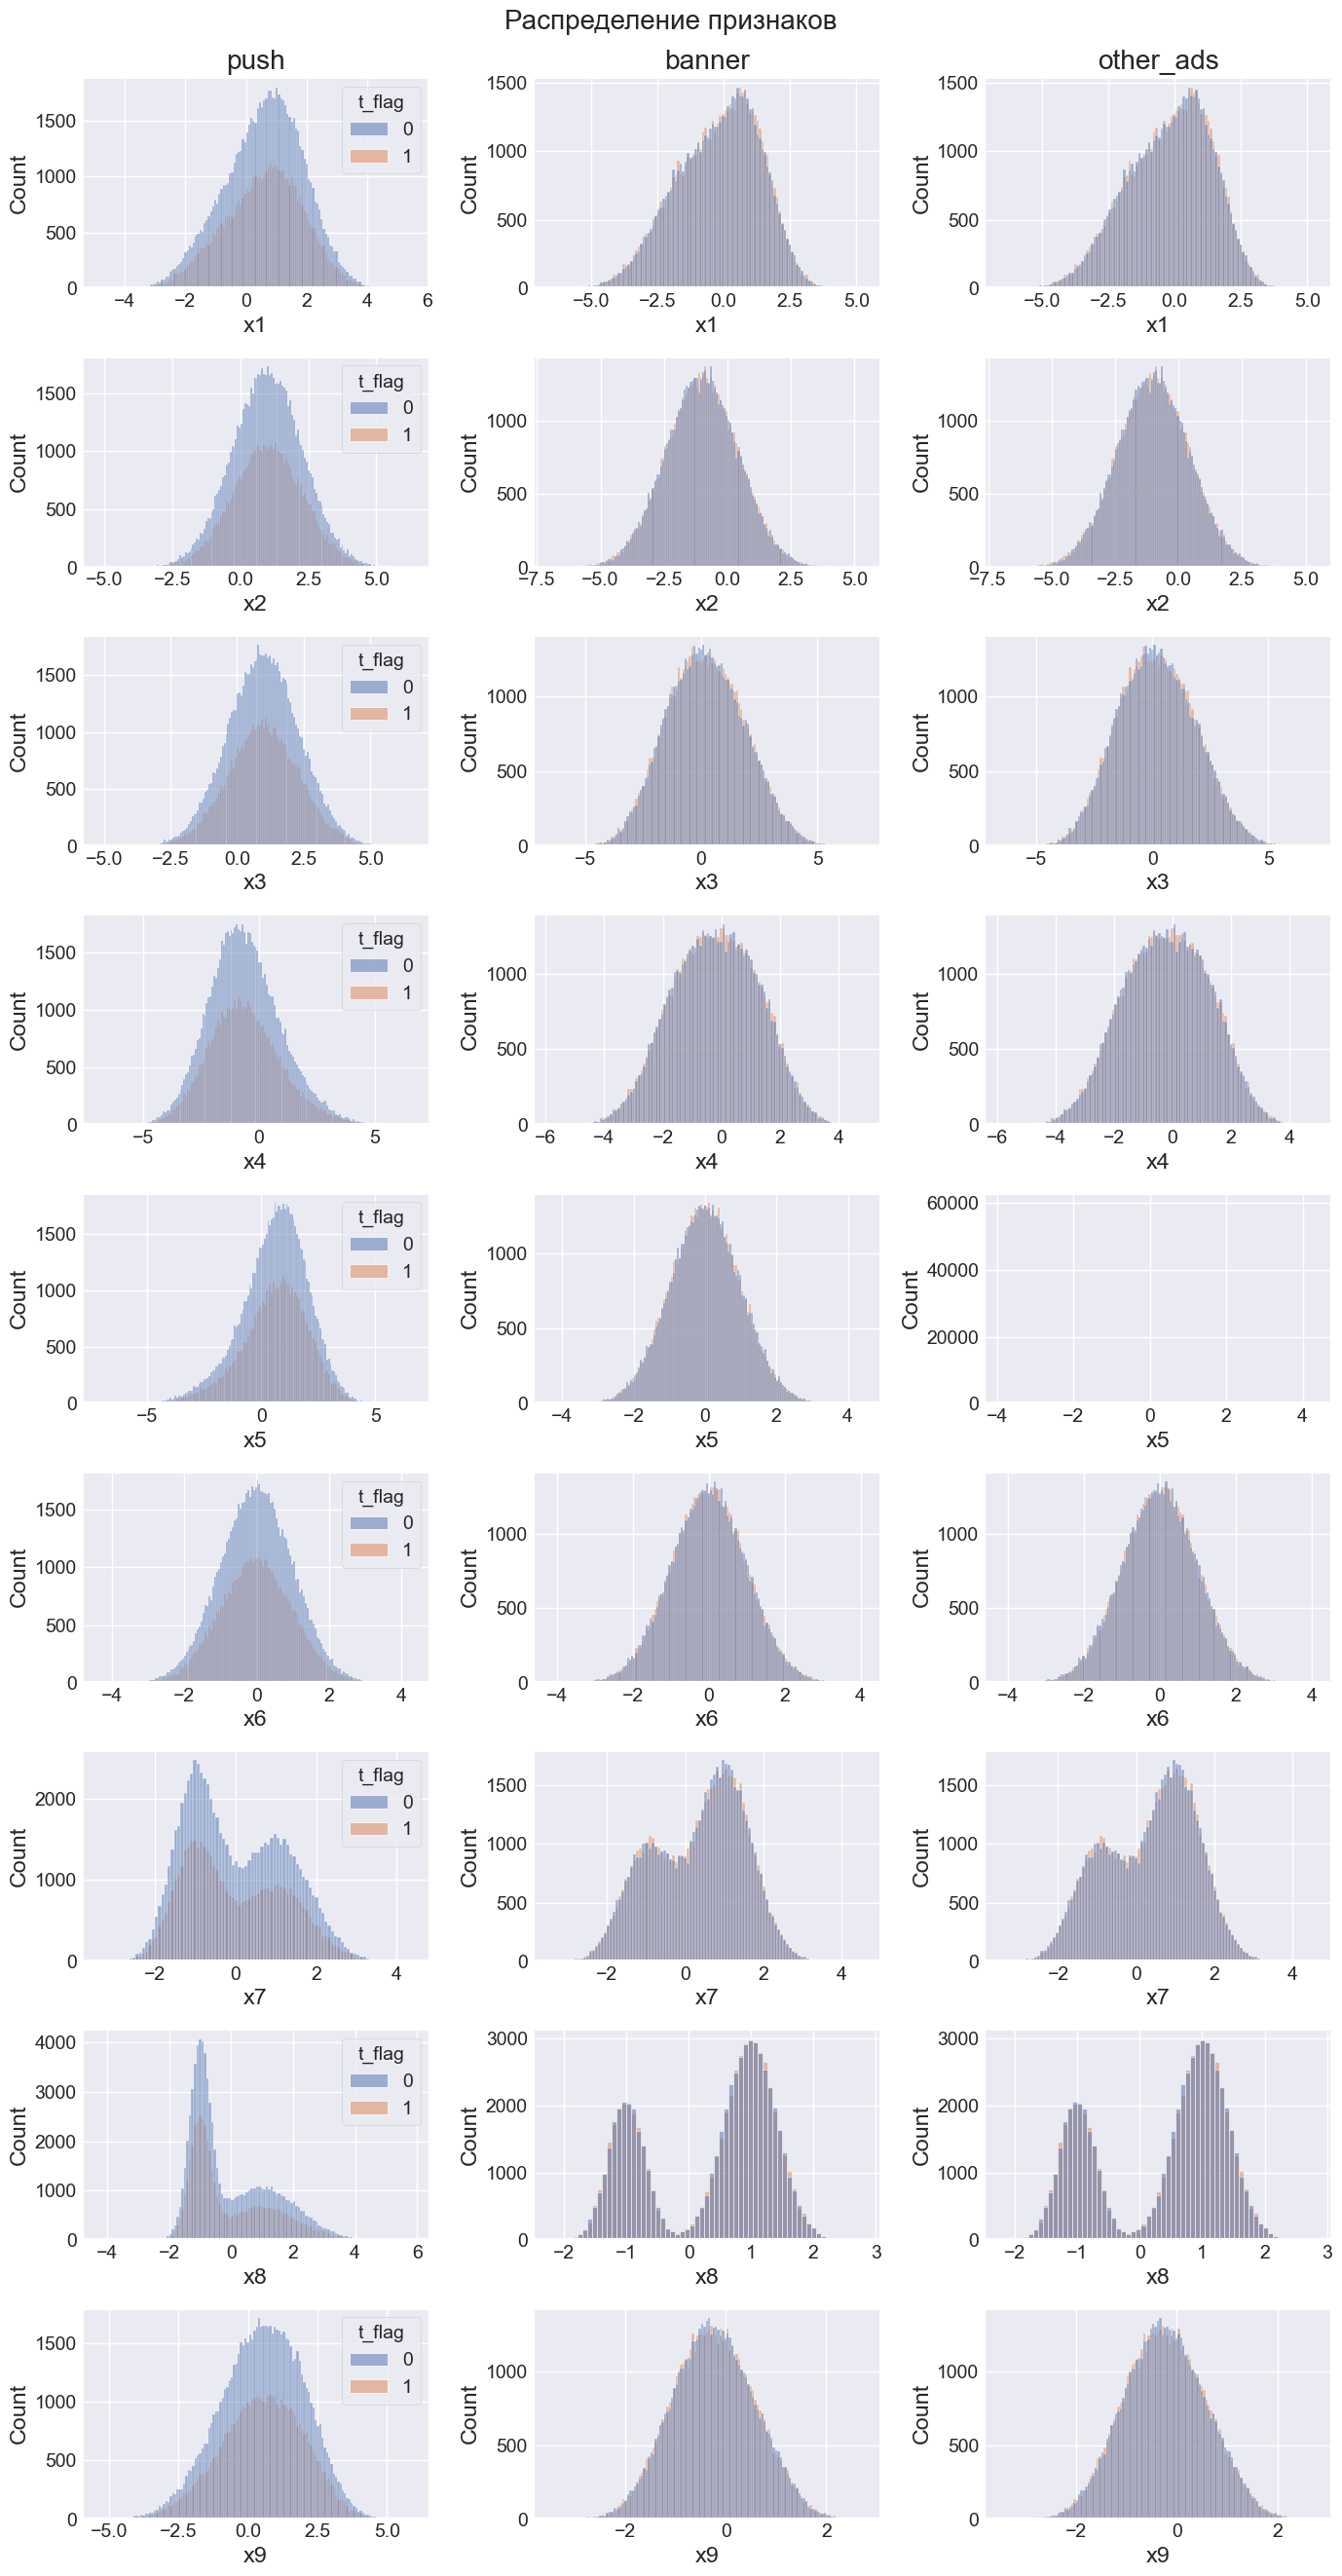

In [16]:
# Канва для графиков распределения признаков в разных кампаниях
feature_cols = df_merged.columns[5:14]
fig, axs = plt.subplots(nrows=len(feature_cols), ncols=3, figsize=(14, len(feature_cols)*3))
fig.suptitle('Распределение признаков', size=20)

# Подписываем группы графиков (заголовки для первого ряда осей)
axs[0, 0].set_title('push')
axs[0, 1].set_title('banner')
axs[0, 2].set_title('other_ads')

# Распределения признаков
for i, feature in enumerate(feature_cols):
    
    # График для push
    sns.histplot(data=df_merged[df_merged['channel'] == 'push'],
                 x=feature, hue='t_flag', ax=axs[i, 0])
    
    # График для banner
    sns.histplot(data=df_merged[df_merged['channel'] == 'banner'],
                 x=feature, hue='t_flag', ax=axs[i, 1], legend=False)
    
    # График для other_ads
    sns.histplot(data=df_merged[df_merged['channel'] == 'other_ads'],
                 x=feature, hue='t_flag', ax=axs[i, 2], legend=False)
    
plt.tight_layout(rect=[0, 0, 1, 0.99])  
plt.show()

`Выводы`
* Для всех трёх типов кампаний распределения признаков x1-x6 выглядят почти нормальным, но при этом для push часто видна иная центровка и ширина распределения: где-то пик смещён влево или вправо относительно нуля, а разброс может быть чуть больше или меньше. Это может говорить о том, что по этим признакам аудитория, реагирующая на push-уведомления, отличается от той, что видит баннеры или другие типы рекламы и что признаки в push-кампании сильнее дифференцируют класс 1 и 0
* Для признаков x7, x8 ярко выражена мультимодальность (несколько пиков) для всех типов кампаний, но у banner и other_ads эти пики кажутся более разделёнными, тогда как у push иногда видна дополнительная серединная мода (три пика вместо двух). Наличие нескольких пиков говорит о том, что в выборке по этим признакам может быть микс из нескольких групп наблюдений с разными средними/распределениями (видимо как раз наши контрольная и целевая группы)
* Для признака x9 для push распределение сдвинуто к более высоким значениям, а у banner и other_ads центр ближе к нулю, возможно здесь можем наблюдать отличие в аудитории, которые участвовала в разных кампаниях
* Для кампании other_ads признак x5 занулился, возможно для этой кампании он не рассчитывался или не имеет смысла, но также возможно что в произошла ошибка при сборе данных
* Для кампаний banner и other_ads наблюдается большая схожесть распределений признаков (кроме x5)

In [47]:
# PSI для всех каналов и всех признаков
for c in df_merged['channel'].unique():
    data = df_merged[df_merged['channel']==c]
    for feature in feature_cols:
        psi = calculate_psi(expected = data[data['t_flag']==0][feature],
                            actual = data[data['t_flag']==1][feature])
        if psi > 0.1:  
            print(f'psi для кампании {c} и признака {feature} равен {psi}')

psi для кампании other_ads и признака x5 равен 9.209419337938986


`Выводы`
* Только для одного признака x5 в кампании other_ads psi > 0.1 (данные неоднородны), имеем все основания выкинуть этот признак

### 3. Построение моделей и оценка их качества (14 баллов)

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

#### Подготовка данных

In [18]:
# Делим выборку на train и test
X = df_merged.drop(columns=['user_id', 'report_dt_x', 'report_dt_y', 'target']).copy()
y = df_merged['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)

In [19]:
# OHE для категориальных столбцов
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
cat_cols = X_train.select_dtypes(include='object').columns
X_train_ohe = ohe.fit_transform(X_train[cat_cols])
X_test_ohe = ohe.transform(X_test[cat_cols])

# Забираем названия признаков и создаём датафреймы признаков
feature_names = ohe.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=feature_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=feature_names)

# Создаём ohe датасеты
X_train_ohe = X_train_ohe.join(X_train.select_dtypes(exclude='object').reset_index()).drop(columns='index')
X_test_ohe = X_test_ohe.join(X_test.select_dtypes(exclude='object').reset_index()).drop(columns='index')

# Сбрасываем индекс у таргетов после джоина признаков
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [20]:
X_train_ohe.head(2)

,channel_other_ads,channel_push,city_Smolensk,city_Ufa,t_flag,x1,x2,x3,x4,x5,x6,x7,x8,x9,age
0,1.0,0.0,1.0,0.0,1,1.425773,-0.413957,-0.552172,1.888543,-0.485874,1.316216,0.253460,1.185966,0.069727,31
1,1.0,0.0,1.0,0.0,1,0.859148,-1.425722,-2.844199,1.451950,-0.054406,1.361121,1.494264,1.258238,0.267183,20


In [21]:
# Сразу выделим все признаки и целевые переменные для всех кампаний
# Матрица признаков и вектор целевой переменной для кампании other_ads
X_train_other = (X_train_ohe[X_train_ohe['channel_other_ads']==1]
                 .drop(columns=['channel_other_ads', 'channel_push', 'x5']))
X_test_other = (X_test_ohe[X_test_ohe['channel_other_ads']==1]
                 .drop(columns=['channel_other_ads', 'channel_push', 'x5']))

y_train_other = y_train.loc[X_train_other.index]
y_test_other = y_test.loc[X_test_other.index]

# Матрица признаков и вектор целевой переменной для кампании banner
X_train_banner = ((X_train_ohe[(X_train_ohe['channel_push']==0)&(X_train_ohe['channel_other_ads']==0)])
                  .drop(columns=['channel_other_ads', 'channel_push']))
X_test_banner = ((X_test_ohe[(X_test_ohe['channel_push']==0)&(X_test_ohe['channel_other_ads']==0)])
                  .drop(columns=['channel_other_ads', 'channel_push']))

y_train_banner = y_train.loc[X_train_banner.index]
y_test_banner = y_test.loc[X_test_banner.index]

# Матрица признаков и вектор целевой переменной для кампании push
X_train_push = ((X_train_ohe[(X_train_ohe['channel_push']==1)])
                  .drop(columns=['channel_other_ads', 'channel_push']))
X_test_push = ((X_test_ohe[(X_test_ohe['channel_push']==1)])
                  .drop(columns=['channel_other_ads', 'channel_push']))

y_train_push = y_train.loc[X_train_push.index]
y_test_push = y_test.loc[X_test_push.index]

#### Solomodel LogReg

In [ ]:
# Возьмём кампанию banner и будем на её основе обучать разные модели для подбора лучшей из них
# Как только выберем лучшую, подберём для неё гиперпараметры и затем обучим 3 модели (1 на каждую кампанию)
# Сначала обучим Solomodel с логрегом
model = LogisticRegression(random_state=42, max_iter=5000)
sm_log = SoloModel(estimator=model)

sm_log.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner['t_flag'])
uplift_sm_log = sm_log.predict(X_test_banner.drop(columns='t_flag'))

# На всякий обучение для других кампаний
sm_other = SoloModel(estimator=model)

sm_other.fit(X_train_other.drop(columns='t_flag'), y_train_other, treatment=X_train_other['t_flag'])
sm_push = SoloModel(estimator=model)

sm_push.fit(X_train_push.drop(columns='t_flag'), y_train_push, treatment=X_train_push['t_flag'])

In [23]:
# Функция для построения графиков (hist, qini_curve, uplift_curve)
def plot_uplift(uplift, y_true, index, treatment, campaign):
    # Фигуры и оси
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    ax1, ax2 = axes[0, 0], axes[0, 1]
    fig.delaxes(axes[1, 0])  # Удаляем нижние оси, чтобы создать одну широкую
    fig.delaxes(axes[1, 1])

    # Добавляем ось, занимающую всю ширину
    ax3 = fig.add_subplot(2, 1, 2)

    # Qini-кривая
    plot_qini_curve(y_true, pd.Series(uplift, index=index), treatment, ax=ax1)
    ax1.set_title(f"Qini-кривая ({campaign})")
    ax1.set_xlabel("Количество клиентов")
    ax1.set_ylabel("Кумулятивный эффект кампании")

    # Uplift-кривая
    plot_uplift_curve(y_true, pd.Series(uplift, index=index), treatment, ax=ax2)
    ax2.set_title(f"Uplift-кривая ({campaign})")
    ax2.set_xlabel("Количество клиентов")
    ax2.set_ylabel("Кумулятивный uplift")

    # Гистограмма распределения uplift
    uplift_pd = pd.DataFrame(data = uplift, index = index, columns=['uplift'])
    uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
    sns.histplot(uplift_pd, ax=ax3)
    ax3.set_title(f"Распределение значений uplift ({campaign})")
    ax3.set_xlabel("Uplift")
    ax3.set_ylabel("Частота")
    
    plt.tight_layout()
    plt.show()

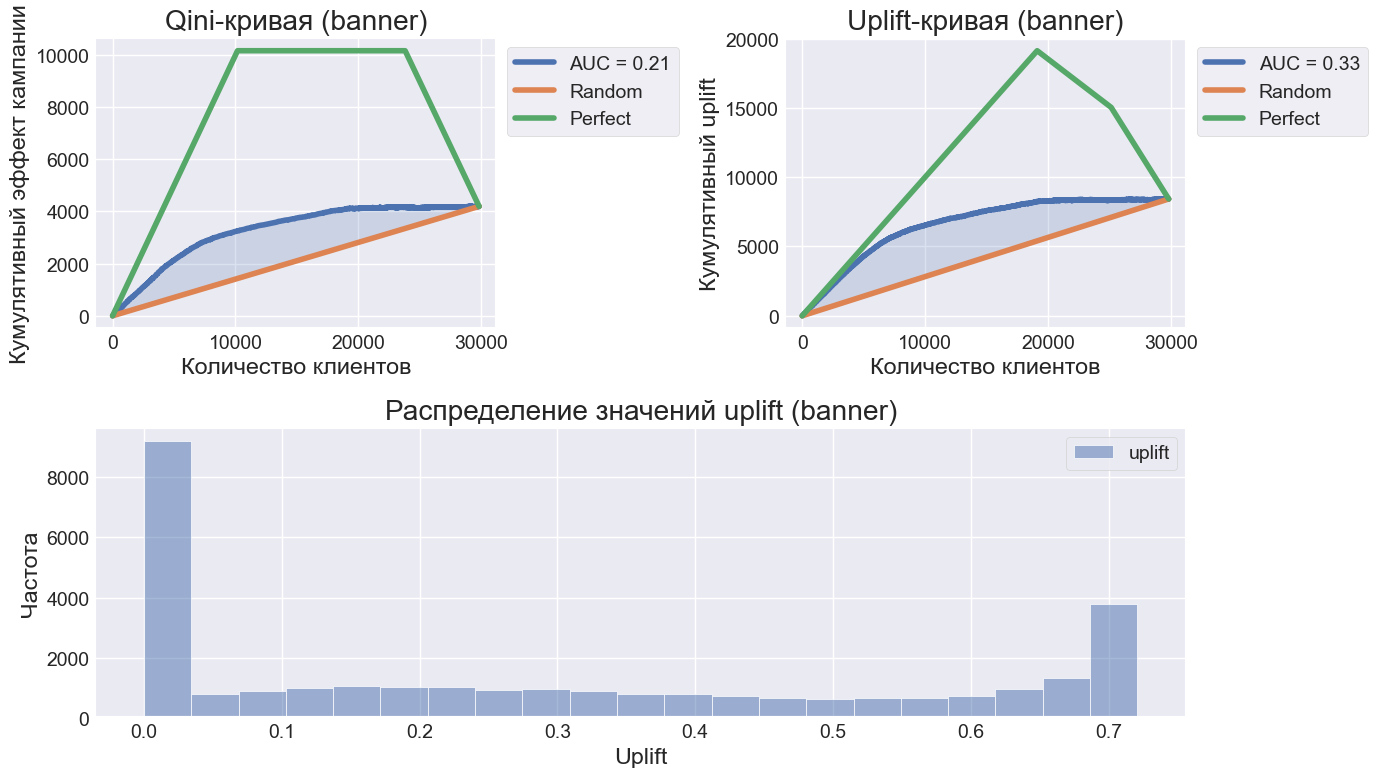

In [24]:
# Графики для логрега
plot_uplift(uplift_sm_log, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

`Выводы`
* Предсказание модели (qini-кривая) находится выше случайного предсказания, но заметно ниже идеального. Это значит, что модель работает лучше случайного выбора, но далеко не оптимально (AUC Score = 0.21)
* Аналогично, uplift-кривая показывает, что модель даёт прирост по сравнению со случайным разбиением, но с большим отставанием от идеального результата (AUC score = 0.33)
* Большая часть значений uplift сосредоточена около нуля, что может говорить о низкой предсказательной способности модели для большинства клиентов. При этом распределение выглядит скошенным вправо, что означает наличие небольшого количества клиентов с высоким uplift

#### Solomodel\Twomodel CatBoost

In [25]:
# Теперь обучим Solomodel CatBoost
cb = CatBoostClassifier(verbose=0, random_seed=42, thread_count=-1)
sm_cb = SoloModel(estimator=cb)

sm_cb.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner['t_flag'])
uplift_sm_cb = sm_cb.predict(X_test_banner.drop(columns='t_flag'))

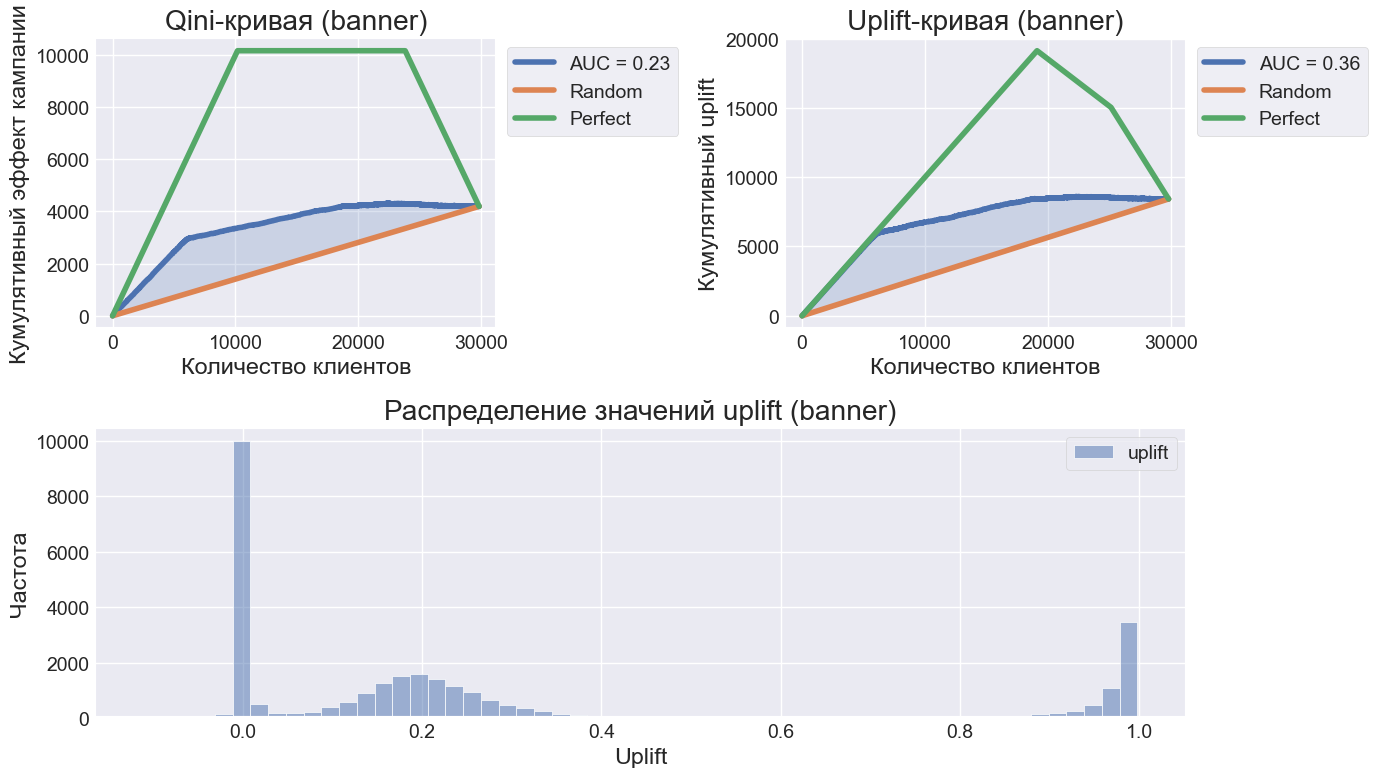

In [26]:
# Графики для Solomodel CatBoost
plot_uplift(uplift_sm_cb, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

`Выводы`
* Для Qini-кривой значение AUC = 0.23, что выше, чем у модели на логистической регрессии (0.21)
* Аналогично для Uplift-кривой, значение AUC выросло с 0.33 до 0.36
* По распределению значений uplift заметно, что большая часть значений находятся около нуля, но при этом появилась более выраженная правая часть распределения (значения uplift более равномерно распределены по интервалу до 0.4), это говорит о том, что модель стала лучше разделять клиентов и присваивать им более различающиеся uplift-значения, также есть небольшое количество выбросов около значения uplift=1
* В целом CatBoost справился лучше, чем Логистическая регрессия

In [27]:
# Теперь попробуем TwoModels для CatBoost
cb_2 = CatBoostClassifier(verbose=0, random_seed=43, thread_count=-1)
tm_cb = TwoModels(estimator_trmnt=cb, estimator_ctrl=cb_2)

tm_cb.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner['t_flag'])
uplift_tm = tm_cb.predict(X_test_banner.drop(columns='t_flag'))

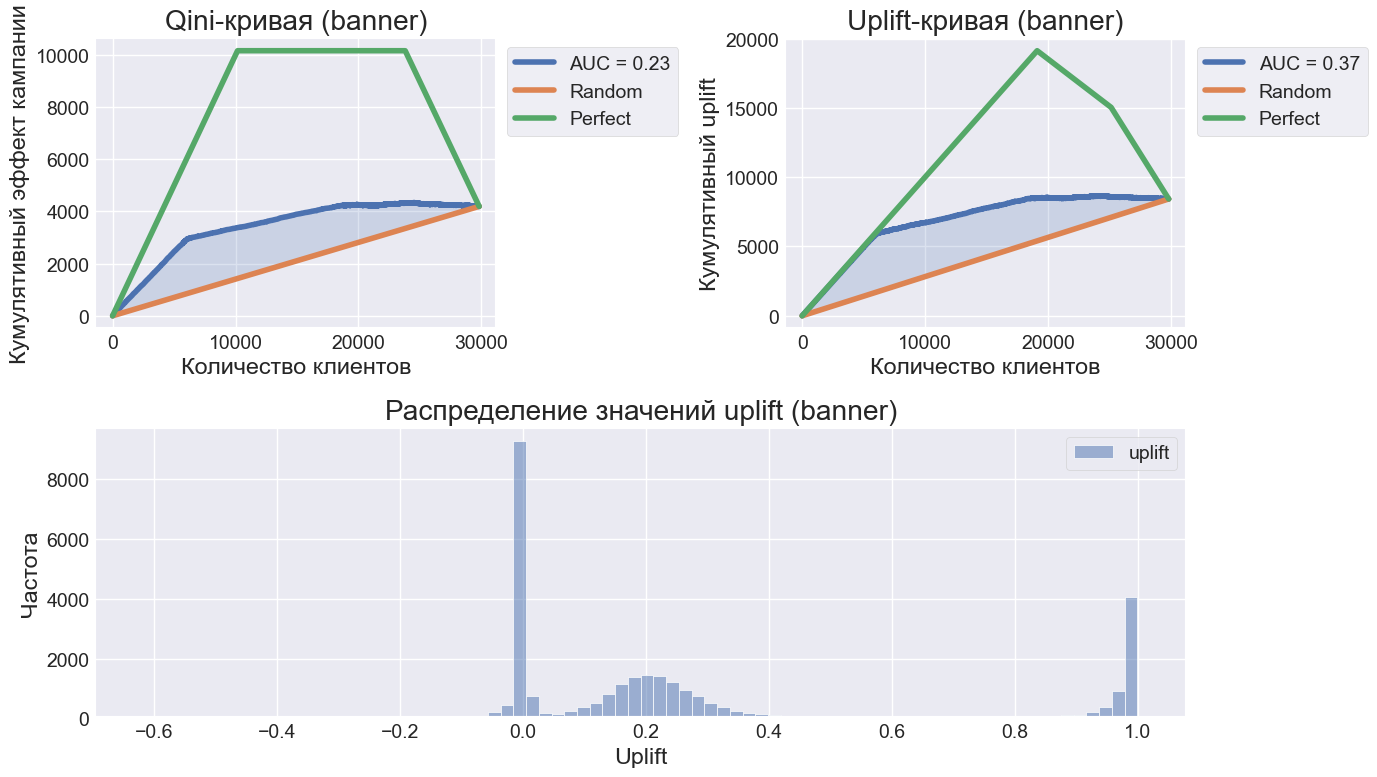

In [28]:
# Графики для TwoModel CatBoost
plot_uplift(uplift_tm, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

`Выводы`
* Для Qini-кривой и распределения значений uplift без изменений по сравнению с Solomodel CatBoost, для Uplift-кривой немного выросло значение AUC (с 0.36 до 0.37)
* На графике распределения uplift есть небольшое количество отрицательных значений (клиенты, которым лучше не направлять коммуникацию)

#### Калибровка CatBoost

In [29]:
# Откалибруем CatBoost
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
calib_model = CalibratedClassifierCV(estimator=cb, method='isotonic', cv=skf)
sm_calib = SoloModel(calib_model)

sm_calib.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner['t_flag'])
uplift_sm_calib = sm_calib.predict(X_test_banner.drop(columns='t_flag'))

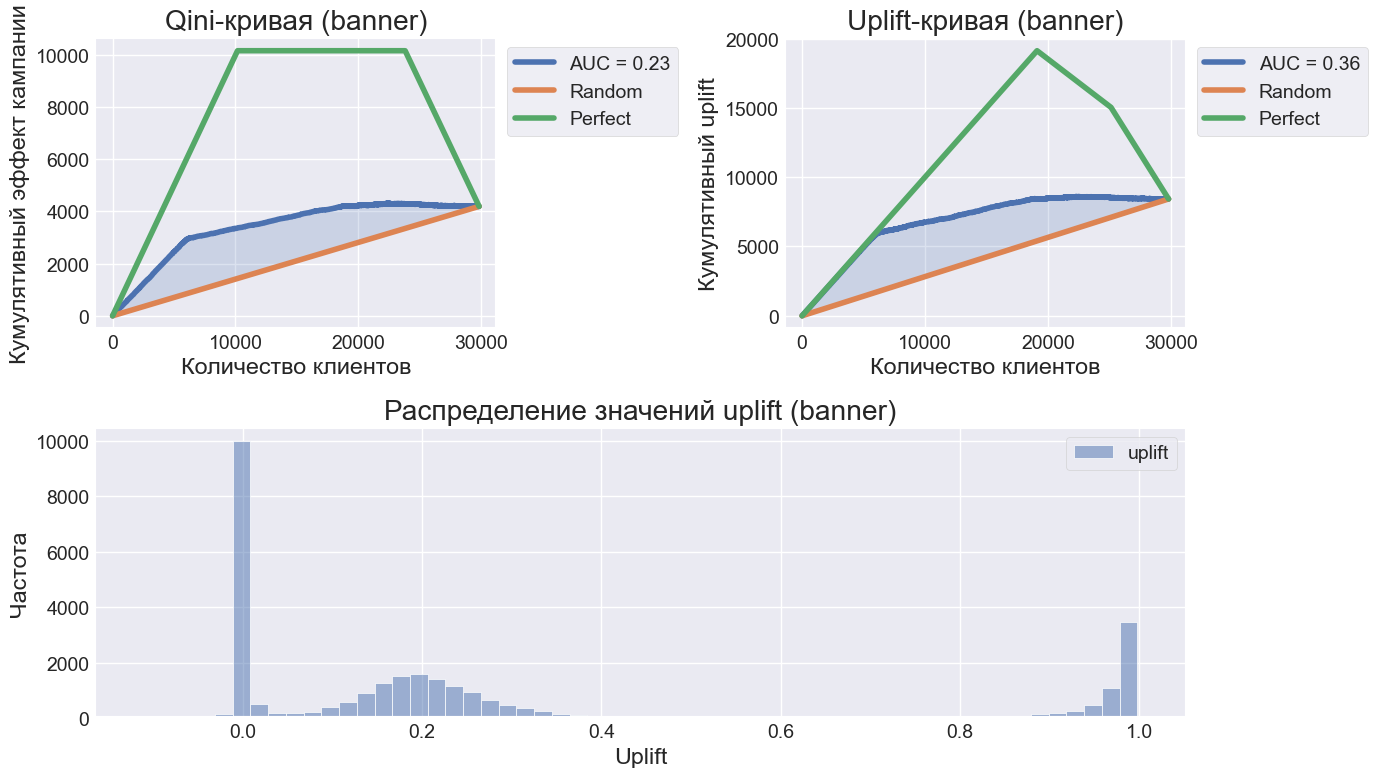

In [30]:
# Графики для калиброванного catboost
plot_uplift(uplift_sm_cb, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

`CatBoost откалибровали, теперь можем спокойно брать вероятности предсказаний этой модели`

#### ClassTransformation

In [31]:
# Воспользуемся преобразованием классов (ClassTransformation)
ct = ClassTransformation(cb)
ct = ct.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner['t_flag'])
uplift_ct = ct.predict(X_test_banner.drop(columns='t_flag'))

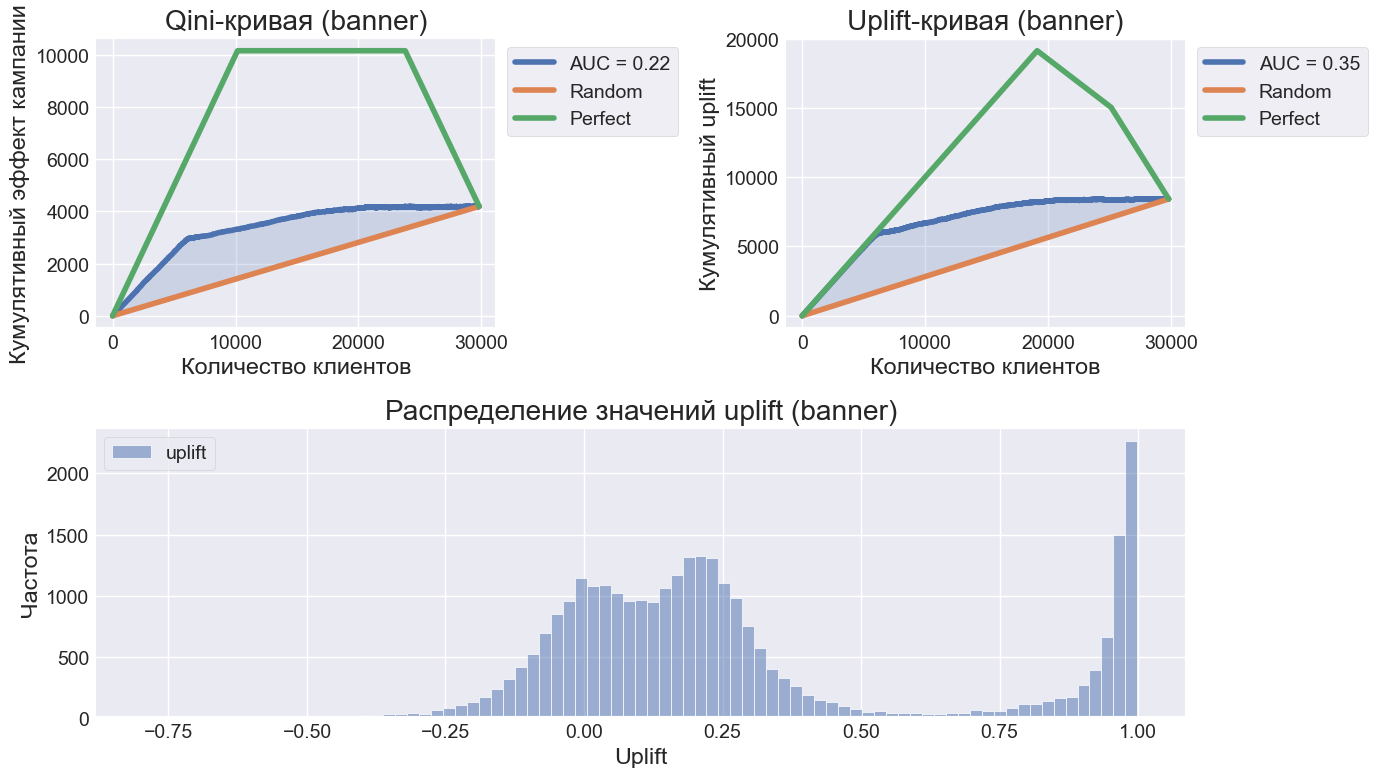

In [32]:
# Графики для ClassTransformation
plot_uplift(uplift_ct, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

`Выводы`
* После преобразования классов для Qini-кривой значение AUC немного уменьшилось С 0.23 до 0.22
* Для Uplift-кривой похожая ситуация, снижение AUC с 0.36 до 0.35
* Распределение uplift по сравнению с прошлыми версиями стало более плавным и похоже на нормальное с небольшим перекосом вправо
* Появились отрицательные значения uplift, что может говорить о том, что модель теперь лучше идентифицирует клиентов, которым не стоит предлагать определенную кампанию, также наблюдается пик в районе 1, что может указывать на клиентов с очень высоким прогнозируемым uplift

#### UpliftRandomForest

In [33]:
# Построим UpliftRandomForest
uplift_forest = UpliftRandomForestClassifier(control_name='0', random_state=42, n_jobs=-1)

# Создаём новые переменные для UpliftRandomForestClassifier
X_train_urf = X_train_banner.copy()
X_train_urf['t_flag'] = X_train_urf['t_flag'].astype(str)
X_test_urf = X_test_banner.copy()
X_test_urf['t_flag'] = X_test_urf['t_flag'].astype(str)

uplift_forest.fit(X=X_train_urf.drop(columns='t_flag').values, y=y_train_banner.values, treatment=X_train_urf['t_flag'].values)
uplift_urf = uplift_forest.predict(X_test_urf.drop(columns='t_flag').values)

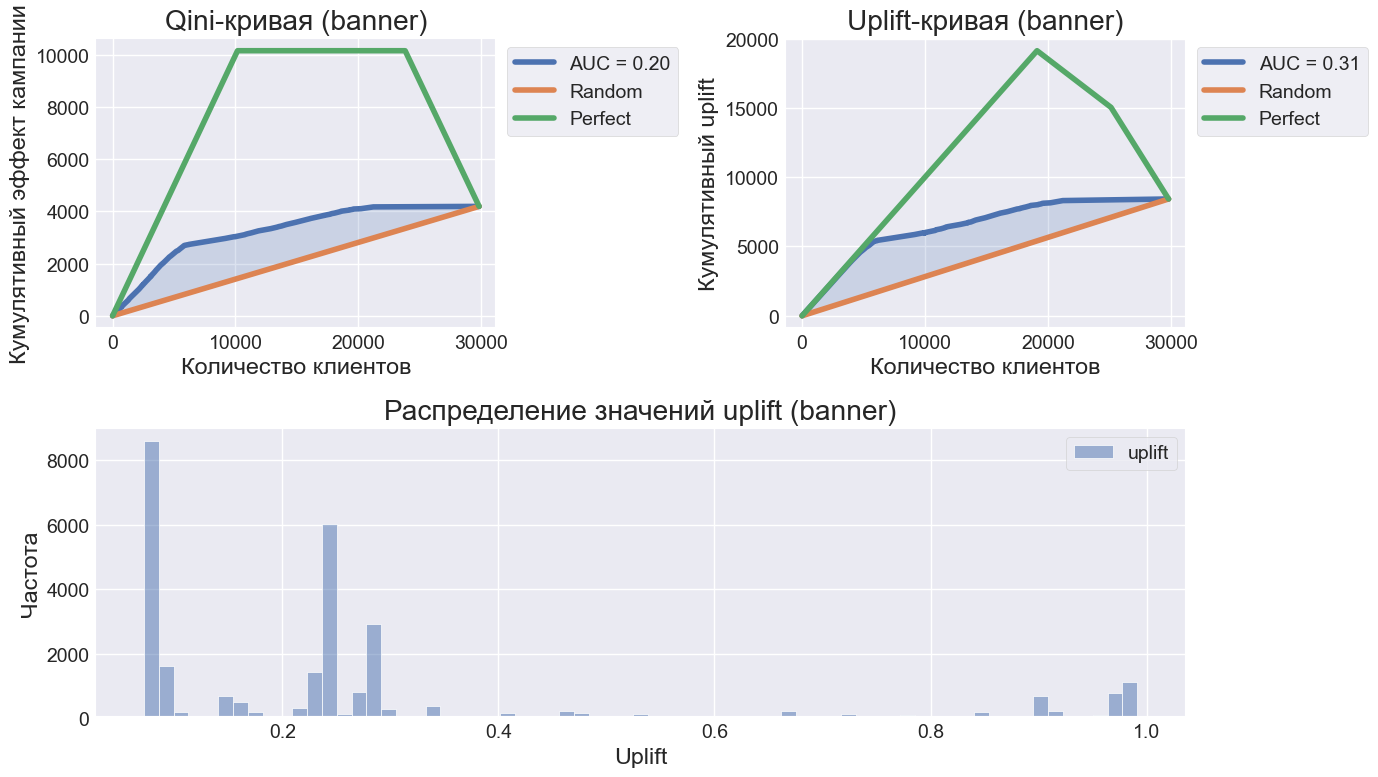

In [34]:
# Графики для UpliftRandomForest
plot_uplift(uplift_urf.flatten(), y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

`Выводы`
* Для Qini-кривой AUC уменьшился с 0.23 до 0.2
* Для Uplift-кривой AUC также снизился с 0.36 до 0.31
* Распределение uplift разорванное и несглаженное, присутствуют несколько выраженных пиков
* В целом UpliftRandomForest показал более плохие результаты по сравнению с Solomodel Catboost

#### Pipeline

In [35]:
# Построим небольшой пайплайн и применим его
pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                       ('model_uplift', sm_cb)])

pipe.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, model_uplift__treatment=X_train_banner['t_flag'])
uplift_pipe = pipe.predict(X_test_banner.drop(columns='t_flag'))

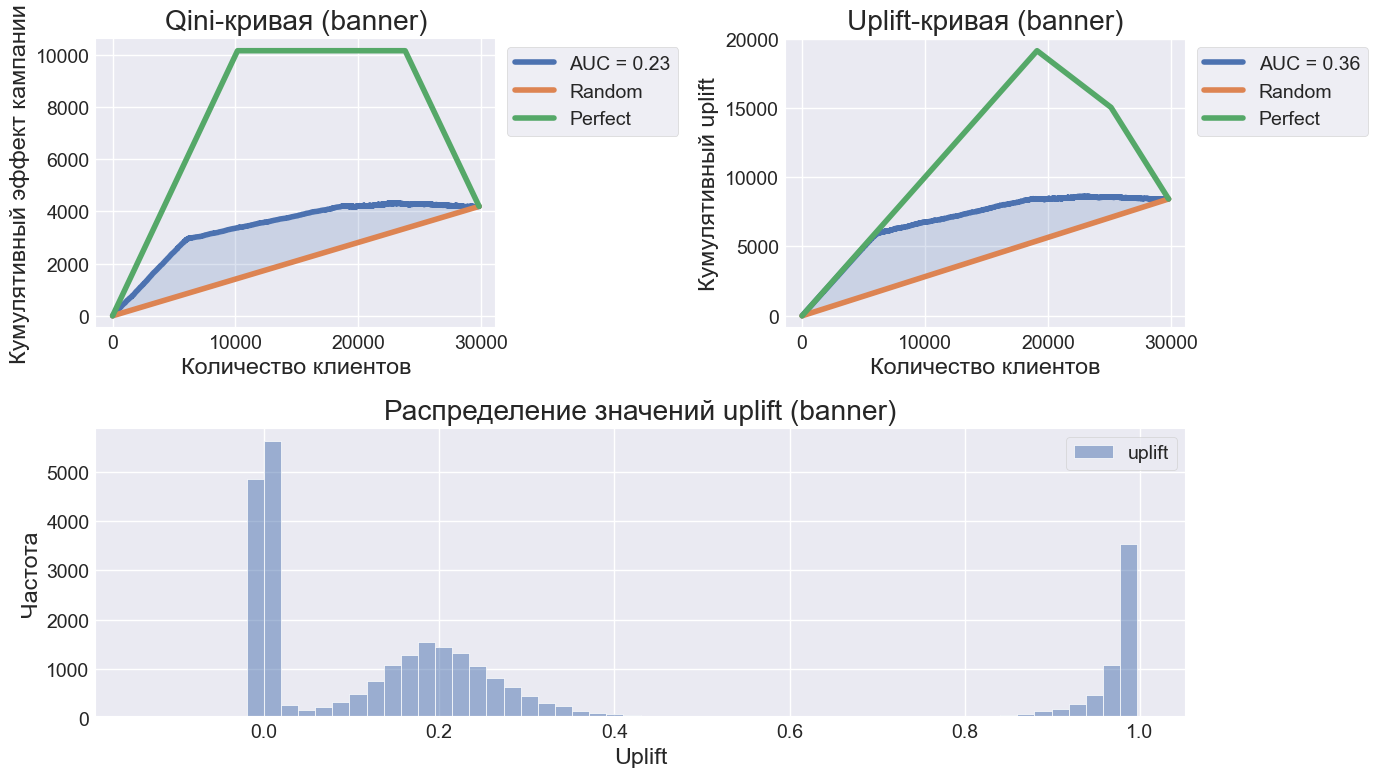

In [36]:
# Графики для Пайплайна
plot_uplift(uplift_pipe, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

`Выводы`
* После применения MinMaxScaler качество осталось точно таким же, как и для SoloModel Catboost без применения скалирования

#### Optuna

In [ ]:
# Проведем тюнинг через optuna модели Solomodel Logreg (проверял CatBoost - гиперпараметры подбираются примерно вечность)
def objective_lr(trial):    
    C = trial.suggest_float("C", 1e-4, 10.0)
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    max_iter = trial.suggest_int("max_iter", 100, 5000)

    # Задаём модель
    model = LogisticRegression(
        C = C,
        solver = solver,
        max_iter = max_iter,
        random_state = 42)
    
    sm = SoloModel(estimator=model)

    qini_scorer = make_uplift_scorer("qini_auc_score", X_train_banner['t_flag'])

    score = cross_validate(sm, X_train_banner.drop(columns='t_flag'), y_train_banner, params={'treatment':X_train_banner['t_flag']}, cv=5, scoring=qini_scorer, n_jobs=-1)
    return score['test_score'].mean() - score['test_score'].std()


study = optuna.create_study(direction="maximize")
study.optimize(objective_lr, n_trials=50)

In [ ]:
# Результаты
print("Лучшие параметры:", study.best_params)

# Обучение модели с лучшими параметрами
best_params = study.best_params
best_model = LogisticRegression(**best_params, random_state=42)
sm_best = SoloModel(estimator=best_model)
sm_best.fit(X_train_banner.drop(columns='t_flag'), y_train_banner, treatment=X_train_banner['t_flag'])
uplift_best = sm_best.predict(X_test_banner.drop(columns='t_flag'))

Лучшие параметры: {'C': 3.3385650535566485, 'solver': 'lbfgs', 'max_iter': 4486}


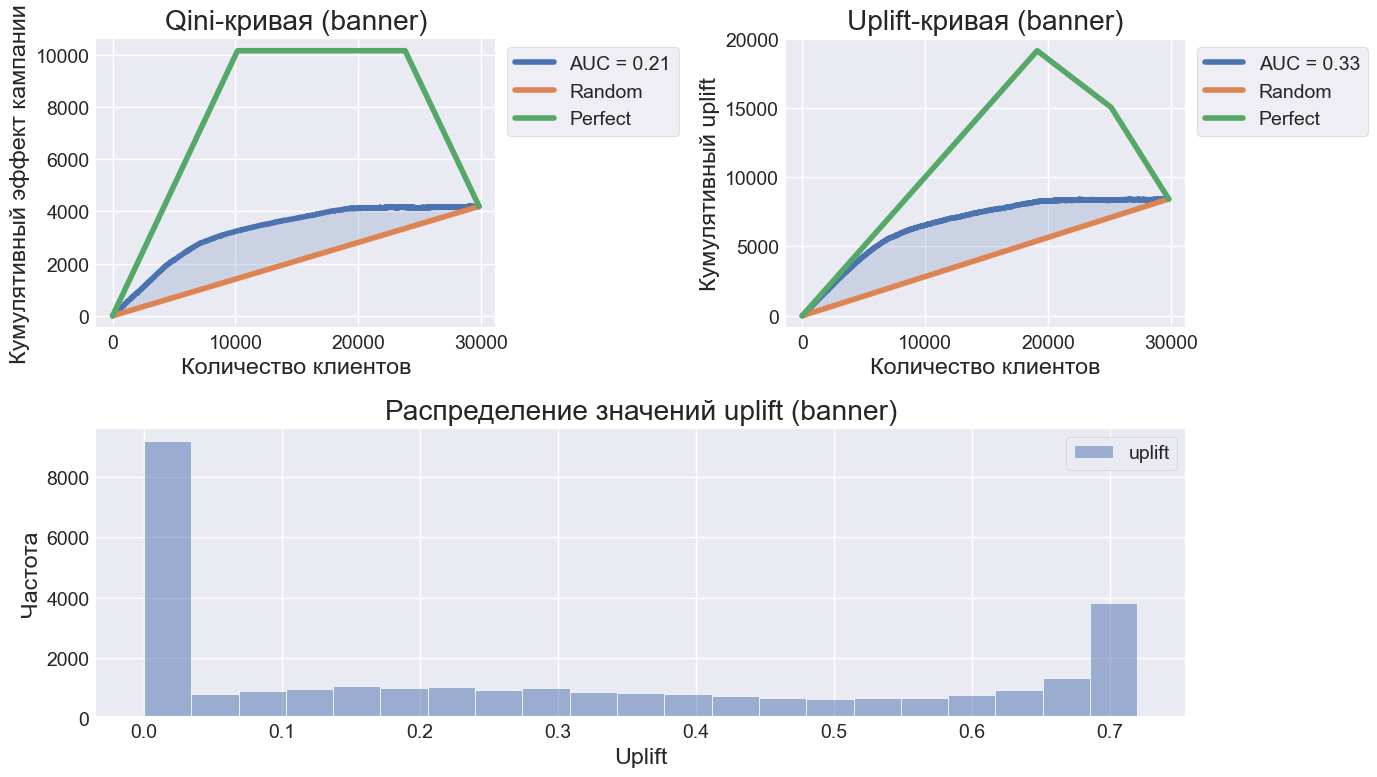

In [ ]:
# Графики для кампании banner
plot_uplift(uplift_best, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

In [ ]:
# Значения метрик
display(qini_auc_score(y_true=y_test_banner,
                       uplift=pd.Series(uplift_sm_log, index=X_test_banner.index),
                       treatment=X_test_banner['t_flag']))

display(qini_auc_score(y_true=y_test_banner,
                       uplift=pd.Series(uplift_best, index=X_test_banner.index),
                       treatment=X_test_banner['t_flag']))

0.20521431323814446

0.20517303437480008

`Выводы`
* Имеем прирост качества по метрике qini_auc_score в одну десятитысячную, для финального предикта по другим кампаниям будем использовать ванильный CatBoost (метрики у него лучше)

#### Метрики и графики для всех трёх кампаний

In [38]:
# Теперь строим графики с лучшей моделью (Catboost) для других кампаний
# push-кампания
push_cb = SoloModel(estimator=cb)
push_cb.fit(X_train_push.drop(columns='t_flag'), y_train_push, treatment=X_train_push['t_flag'])
uplift_push = push_cb.predict(X_test_push.drop(columns='t_flag'))

# other_ads-кампания
other_cb = SoloModel(estimator=cb)
other_cb.fit(X_train_other.drop(columns='t_flag'), y_train_other, treatment=X_train_other['t_flag'])
uplift_other = other_cb.predict(X_test_other.drop(columns='t_flag'))

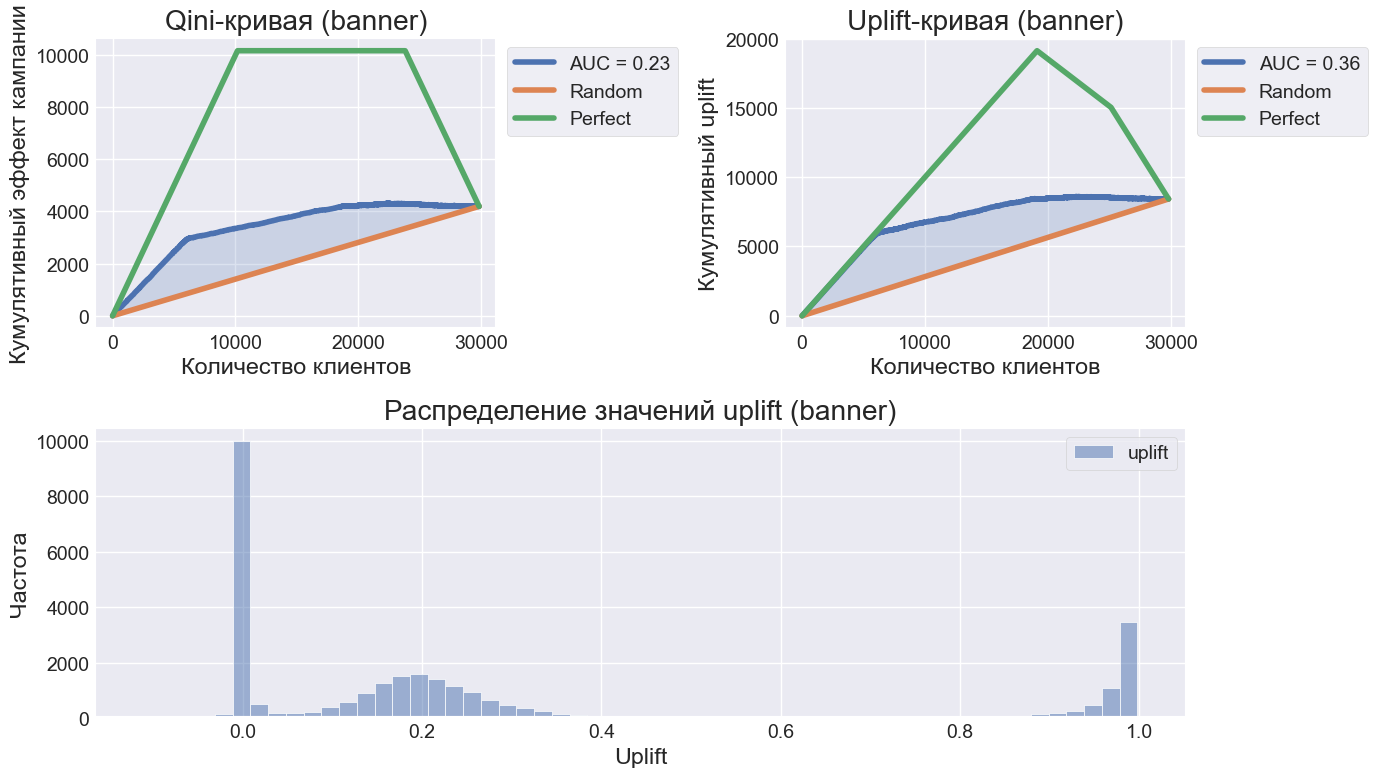

In [39]:
# Графики для кампании banner
plot_uplift(uplift_sm_cb, y_test_banner, X_test_banner.index, X_test_banner['t_flag'], campaign='banner')

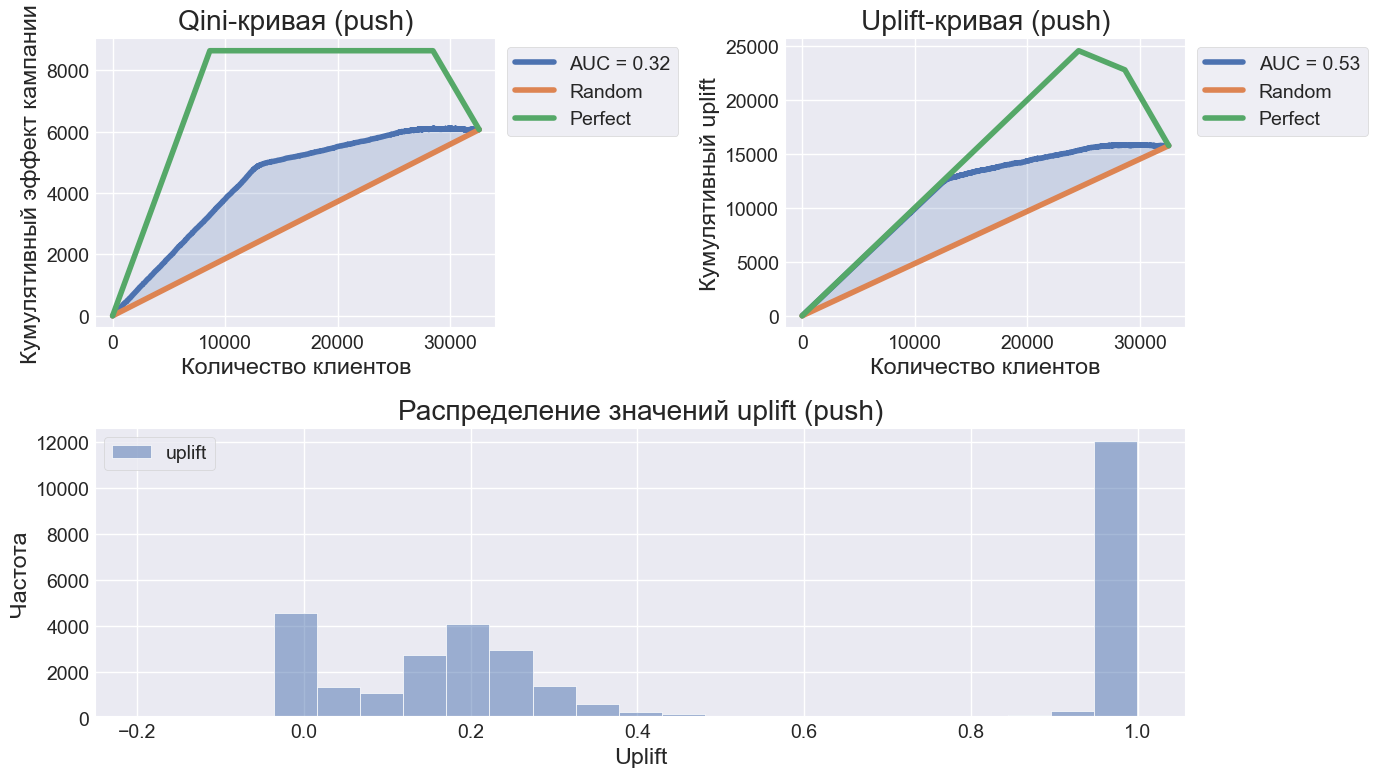

In [40]:
# Графики для кампании push
plot_uplift(uplift_push, y_test_push, X_test_push.index, X_test_push['t_flag'], campaign='push')

`Выводы`
* Qini AUC = 0.32 - значительно лучше, чем в других компаниях (0.23), Uplift AUC = 0.53 - это наилучший результат среди всех кампаний (0.36-0.37)
* По наличию несколько пиков в распределении uplift можно сделать вывод, что модель выделяет несколько сегментов клиентов

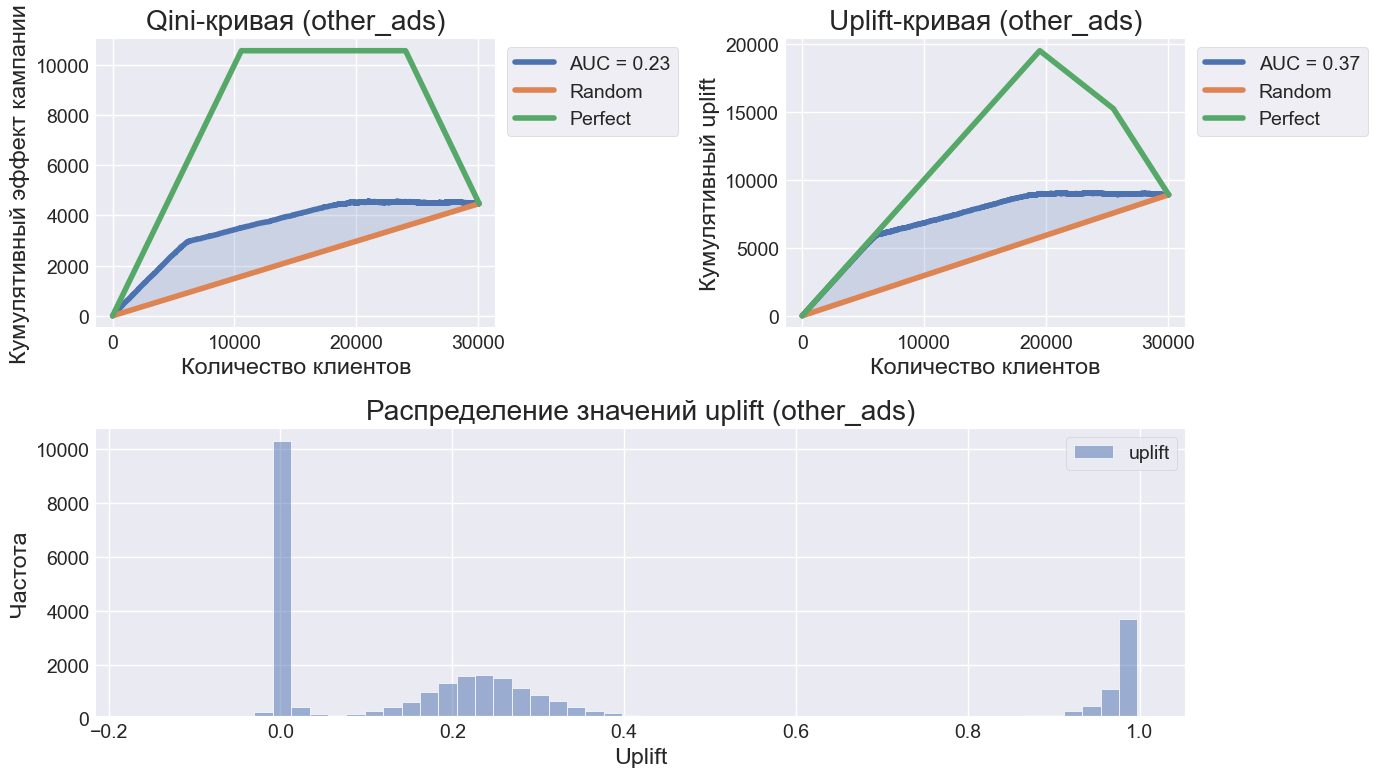

In [41]:
# Графики для кампании other_ads
plot_uplift(uplift_other, y_test_other, X_test_other.index, X_test_other['t_flag'], campaign='other_ads')

`Выводы`
* Qini AUC = 0.23 (на уровне кампании banner), Uplift AUC = 0.37 - ниже, чем у push (0.53) и немного выше, чем у banner (0.36)
* Распределение uplift напоминает такое же как у кампании banner

### 4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

#### Подготовка данных

In [80]:
# Соберём выборку за нужный нам временной период (январь) для предсказания на март
features_january = features[features['report_dt'].dt.month == 1].drop(columns=['report_dt'])

# OHE для категориальных столбцов
ohe_new = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
jan_cat_cols = features_january.select_dtypes(include='object').columns
jan_ohe = ohe_new.fit_transform(features_january[jan_cat_cols])

# Забираем названия признаков и создаём датафреймы признаков
feature_names_jan = ohe_new.get_feature_names_out()
X_ohe = pd.DataFrame(jan_ohe, columns=feature_names_jan)
X_ohe = X_ohe.join(features_january.select_dtypes(exclude='object').reset_index()).drop(columns='index')

In [81]:
X_ohe.head(2)

,city_Smolensk,city_Ufa,x1,x2,x3,x4,x5,x6,x7,x8,x9,user_id,age
0,0.0,1.0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,1066338,26
1,0.0,0.0,0.238281,-1.221378,0.338246,2.578613,-0.738267,-0.293309,-1.623151,-0.419945,-0.285695,25872,42


In [ ]:
# Теперь делаем 3 предикта (для каждой кампании)
# Итоговый предикт делаю для логрег-моделей (почему-то для разных моделей CatBoost предикты были одинаковые)
uplift_ban_jan = sm_log.predict(X_ohe.drop(columns='user_id'))
uplift_push_jan = sm_push.predict(X_ohe.drop(columns='user_id'))
uplift_other_jan = sm_other.predict(X_ohe.drop(columns='user_id'))

# Значения uplift
X_ohe['uplift_banner'] = uplift_ban_jan
X_ohe['uplift_push'] = uplift_push_jan
X_ohe['uplift_other_ads'] = uplift_other_jan

# Вычисляем максимальное значение uplift для каждого клиента
X_ohe['channel'] = X_ohe[['uplift_banner', 'uplift_push', 'uplift_other_ads']].idxmax(axis=1)
X_ohe['channel'] = X_ohe['channel'].str.replace('uplift_', '')
X_ohe['uplift'] = X_ohe[['uplift_banner', 'uplift_push', 'uplift_other_ads']].max(axis=1)

# Если максимальное значение uplift меньше 0, устанавливаем 'no_comm'
X_ohe.loc[X_ohe['uplift'] < 0, 'channel'] = 'no_comm'

In [83]:
X_ohe.head(2)

,city_Smolensk,city_Ufa,x1,x2,x3,x4,x5,x6,x7,x8,x9,user_id,age,uplift_banner,uplift_push,uplift_other_ads,channel,uplift
0,0.0,1.0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,1066338,26,0.006318,0.563819,0.563819,push,0.563819
1,0.0,0.0,0.238281,-1.221378,0.338246,2.578613,-0.738267,-0.293309,-1.623151,-0.419945,-0.285695,25872,42,0.015844,0.174871,0.174871,push,0.174871


#### Графики и выводы

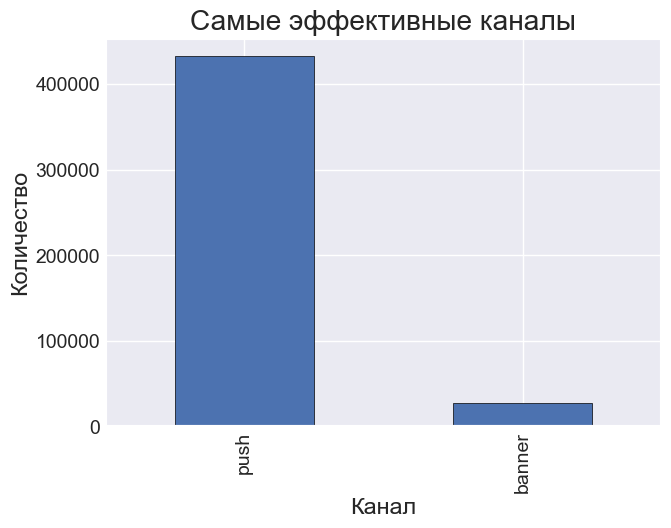

In [89]:
# Эффективность каналов
# Подсчёт количества строк, где канал является максимальным по uplift
channel_counts = X_ohe['channel'].value_counts()
channel_counts.plot(kind='bar', edgecolor='black')
plt.title("Самые эффективные каналы")
plt.xlabel("Канал")
plt.ylabel("Количество")
plt.show()

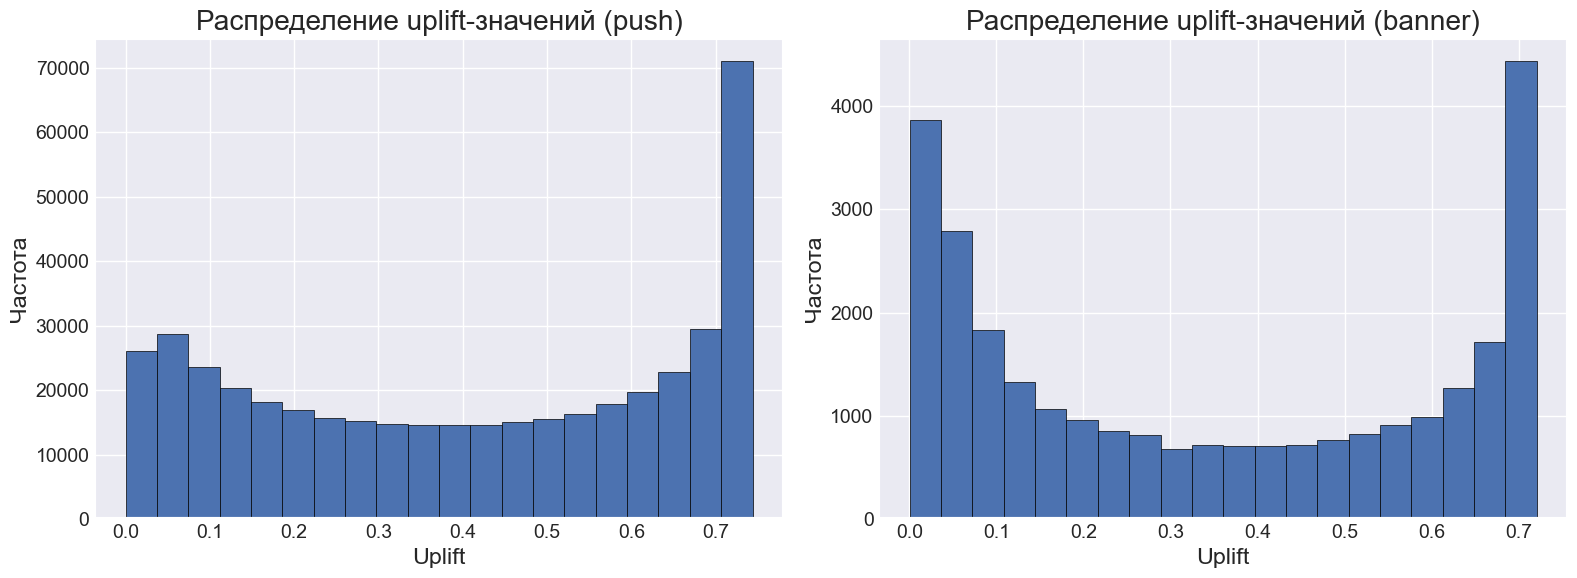

In [92]:
# Строим графики распределений uplift по каналам
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Распределение для канала push
axes[0].hist(X_ohe[X_ohe['channel']=='push']['uplift'], bins=20, edgecolor='black')
axes[0].set_title("Распределение uplift-значений (push)")
axes[0].set_xlabel("Uplift")
axes[0].set_ylabel("Частота")

# Распределение для канала banner
axes[1].hist(X_ohe[X_ohe['channel']=='banner']['uplift'], bins=20, edgecolor='black')
axes[1].set_title("Распределение uplift-значений (banner)")
axes[1].set_xlabel("Uplift")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

`Итоговые выводы`
* Канал push значительно более эффективен по количеству вовлечений, чем banner. Разница между ними значимая: push-сообщения привлекают более 400 000 взаимодействий, тогда как баннеры — менее 50 000
* Для канала push распределение uplift-значений имеет U-образную форму, пик частоты наблюдается как в области низких значений (0.0—0.1), так и в области высоких (0.6—0.7), что говорит о существовании двух основных групп пользователей - одни практически не реагируют на push-уведомления, а другие, наоборот, активно на них откликаются
* Для канала banner наблюдается похожая картина по распределению upluft-значений, но общее количество взаимодействий существенно ниже. В области малых значений (0.0—0.1) частота выше, чем для push, что может свидетельствовать о низкой эффективности этого типа рекламы для большинства пользователей
* На основе вышеперечисленного можно сделать вывод, что для оптимизации рекламной кампании **имеет смысл сосредоточиться на push-уведомлениях** и, возможно, дополнительно разделить пользователей, чтобы выявить группы, наиболее подверженные влиянию баннерной рекламы